In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch import nn
from simulators import SimulatorBlob
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian,LogRatioEstimator_Autoregressive_Gaussian2
import scipy.ndimage
import numpy as np
from PIL import Image, ImageFont, ImageDraw
#import RatioEstimatorCube
from unet import UNet
import scipy.ndimage as ndimage

In [349]:
bounds = None
bounds_n_steps = None

In [397]:
class SimulatorSnake(swyft.Simulator):
    def __init__(self, bounds = None, bounds_n_steps = None, n_max = 50):
        super().__init__()
        self.bounds = bounds
        self.n_max = n_max
        self.bounds_n_steps = bounds_n_steps
        self.transform_samples = swyft.to_numpy32
        
    def get_image(self, turns, n_steps):
        turns = turns[:n_steps[0]]
        directions_angle = np.cumsum(turns)*np.pi/2
        directions_cart = np.array([np.cos(directions_angle), np.sin(directions_angle)]).T
        path = np.array([np.cumsum(directions_cart[:,0]), np.cumsum(directions_cart[:,1])]).T
        img = np.zeros((256, 256))
        idxs = np.floor(path*4).astype(int)+128
        for i, j in idxs:
            if i < 0 or j < 0 or i > 255 or j > 255:
                pass
            else:
                img[i, j] += 1
        img = ndimage.gaussian_filter(img, sigma=1, order=0)
        return img
                
    def get_n_steps(self):
        b = self.bounds_n_steps
        if b is not None:
            return np.random.randint(b[0], b[1]+1, size = (1,))
        else:
            return np.random.randint(10, self.n_max, size = (1,))
    
#    def get_turns(self):
#        turns = np.random.choice([-1, 0, 1], self.n_max, p = [0.1, 0.8, 0.1])
#        return turns
    
    def get_turns(self):
        probs = np.array([[0.1, 0.8, 0.1]]).repeat(self.n_max, axis=0)
        bounds = self.bounds
        if bounds is not None:
            probs = probs*bounds
        indxs = (probs.cumsum(1)/probs.sum(1)[:,None] > np.random.rand(probs.shape[0])[:,None]).argmax(1)
        choices = np.array([-1., 0., 1.])
        return choices[indxs]

    def build(self, graph):
        n_steps = graph.node("n_steps", self.get_n_steps)
        turns = graph.node('turns', self.get_turns)
        img = graph.node('mu', self.get_image, turns, n_steps)

[32]


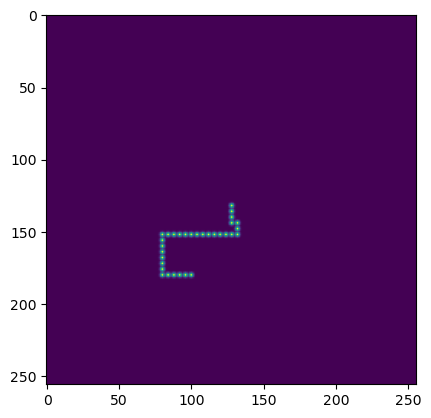

In [401]:
#sim = SimulatorSnake()
#samples0 = sim.sample(1)[0]
#torch.save(samples0, "step4_target.pt")
sample0 = torch.load("step4_target.pt")
mu = samples0['mu']
print(samples0['n_steps'])
plt.imshow(mu)

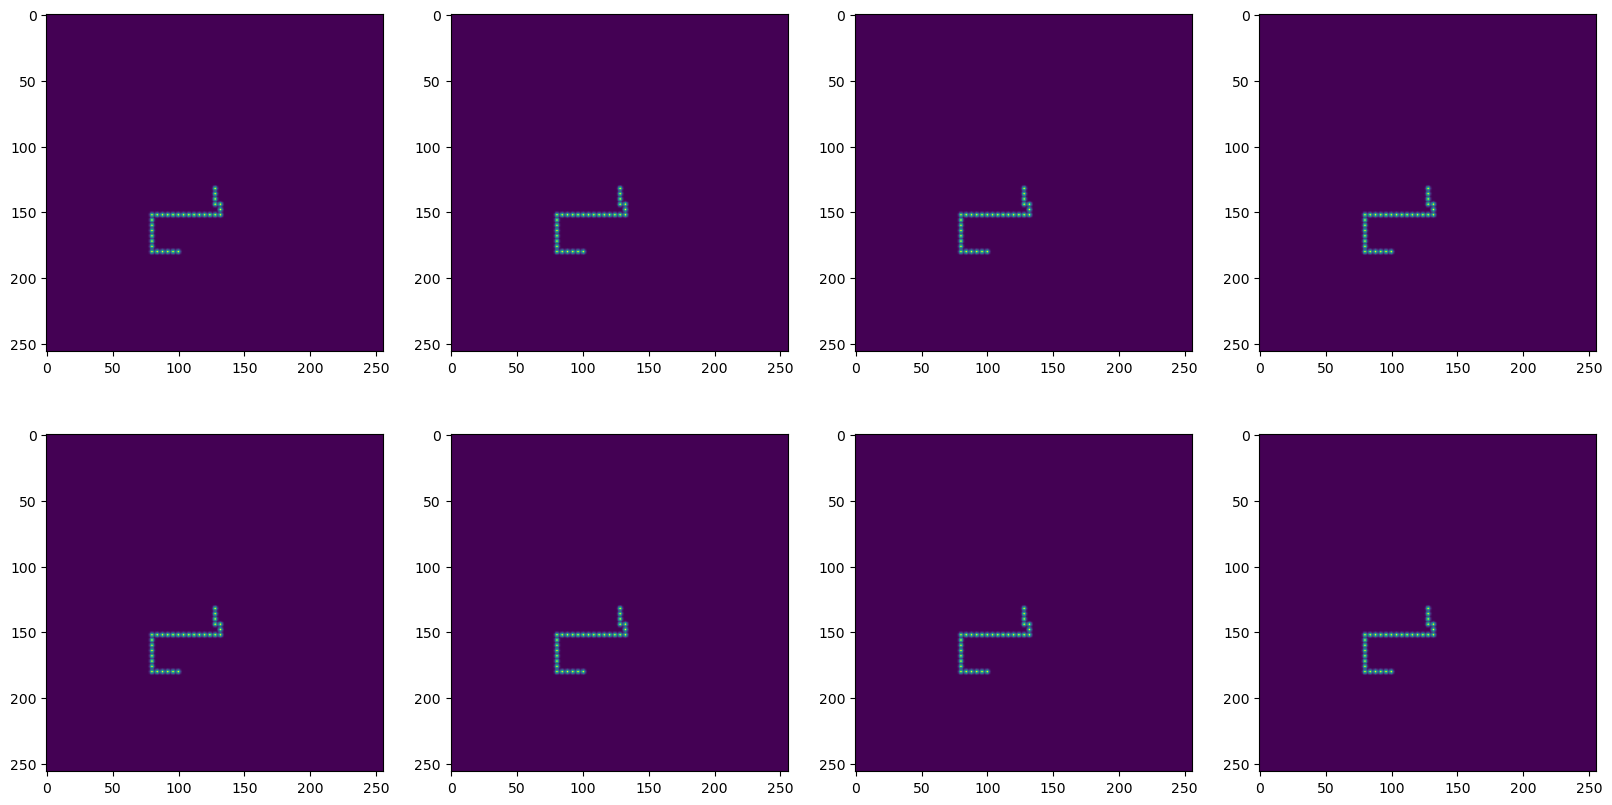

In [402]:
sim = SimulatorSnake(bounds = bounds, bounds_n_steps = bounds_n_steps)
plt.figure(figsize = (20, 10))
for i in range(1, 9):
    plt.subplot(2, 4, i)
    sample = sim.sample()
    t = sample['mu']
    plt.imshow(t)

In [403]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 256, num_params = 1, varnames = 'n_steps')
        self.logratios2 = swyft.LogRatioEstimator_1dim(num_features = 256, num_params = 50, varnames = 'turns')
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.CNN = torch.nn.Sequential(
            torch.nn.LazyConv2d(4, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
            torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2), torch.nn.LazyBatchNorm2d(),
        )
        self.MLP = torch.nn.Sequential(
            torch.nn.LazyLinear(1024), torch.nn.ReLU(),
            torch.nn.LazyLinear(1024), torch.nn.ReLU(),
            torch.nn.LazyLinear(256)
        )

    def forward(self, A, B):
        mu = A['mu']
        f = self.CNN(mu.unsqueeze(1))
        f = torch.flatten(f, start_dim = 1)
        f = self.MLP(f)
        logratios1 = self.logratios1(f, B['n_steps'].float())
        logratios2 = self.logratios2(f, B['turns'].float())
        return logratios1, logratios2
    
net = Network()

In [404]:
sim = SimulatorSnake(bounds = bounds, bounds_n_steps = bounds_n_steps)
samples = sim.sample(8192)
dl = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0], batch_size = 128)

  0%|          | 0/8192 [00:00<?, ?it/s]

In [405]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 20, precision = 32)
trainer.fit(net, dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 33.7 K
1 | logratios2 | LogRatioEstimator_1dim | 1.7 M 
2 | CNN        | Sequential             | 0     
3 | MLP        | Sequential             | 0     
------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.881  

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


  0%|          | 0/10000 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 52it [00:00, ?it/s]

IndexError: invalid index to scalar variable.

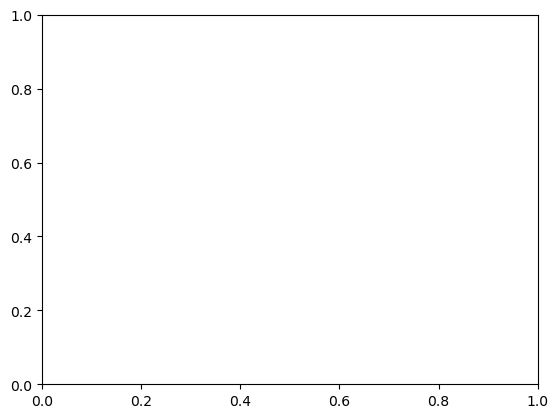

In [406]:
prior_samples = sim.sample(10_000, targets = ['n_steps', 'turns'])
results = trainer.infer(net, samples0, prior_samples)
swyft.plot_1d(results, 'n_steps[0]', smooth = 1)

In [ ]:
bounds_n_steps = swyft.collect_rect_bounds(results[0], 'n_steps', (1,), threshold = 1e-3)[0].long().numpy()
bounds_n_steps

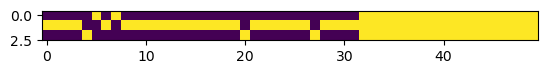

In [407]:
logratios = results[1].logratios*1.
u = results[1].params[..., 0]
out = torch.zeros(50, 3)
for i, v in enumerate([-1., 0., 1.]):
    mask = (u == v)
    ll = logratios*1.
    ll[~mask] = -torch.inf
    lrs = ll.max(dim=0).values
    out[:, i] = lrs
new_bounds = (out > -4).numpy()
if bounds is None:
    current_bounds = 1.
else:
    current_bounds = bounds*1.
plt.imshow((new_bounds*current_bounds).T)

In [408]:
bounds = current_bounds*new_bounds